# Task 1: Graph Cut Segmentation

by Dechathon Niamsa-ard [st126235]

**Instructions:**

- Given 2 images (asm-1, asm2), generate a bounding box for a person in each images by utilizing any deep learning-based object detectors (pretrain model).
- Leveraging the generated bounding boxes, implement graph-based image segmentation using OpenCV function, `cv2.grabCut`.
- Run GrabCut for 1, 3, and 5 iterations — report qualitative and quantitative differences.
- Visualize Results: Display original images, user masks, and final segmentation results (foreground only, and overlay).

**Deliverable:**

- Jupyter notebook with clear code and comments.

## Import necessary libraries and setup the configuration

In [1]:
# Import necessary libraries
import cv2
import numpy as np
import torch
import torchvision
import torchvision.transforms as T
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights
from torchvision.transforms import functional as F
import matplotlib.pyplot as plt
from PIL import Image
import os
from pathlib import Path

In [2]:
# Setup configuration

# Check for GPU availability
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'Using device: {device}')

# Define paths
data_dir = Path('./datasets/task_1/')
images = list(data_dir.glob('*.jpg'))
print(f'Found {len(images)} images for processing.')

# GrabCut parameters
grabcut_iter = [1,3,5]

Using device: cuda
Found 2 images for processing.


In [3]:
# Define a function for visualization
def show_images(images, titles, rows, cols):
    plt.figure(figsize=(15, 10))
    for i, (image, title) in enumerate(zip(images, titles)):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB) if len(image.shape) == 3 else image, cmap='gray')
        plt.title(title)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

## Load pre-trained model for object detector

In [4]:
# Load pre-trained model for object detector
weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT # Use default pre-trained weights
model = fasterrcnn_resnet50_fpn(weights=weights).to(device) # Load model to device
model.eval() # Set model to evaluation mode

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [5]:
# Define transform for input images
transform_image = T.Compose([
    T.ToTensor(),
])

## Load images

In [6]:
# Read the images
input_images = [cv2.imread(str(img_path)) for img_path in images]
image_names = ["asm-1", "asm-2"]
print(f'Loaded {len(input_images)} images.')

Loaded 2 images.


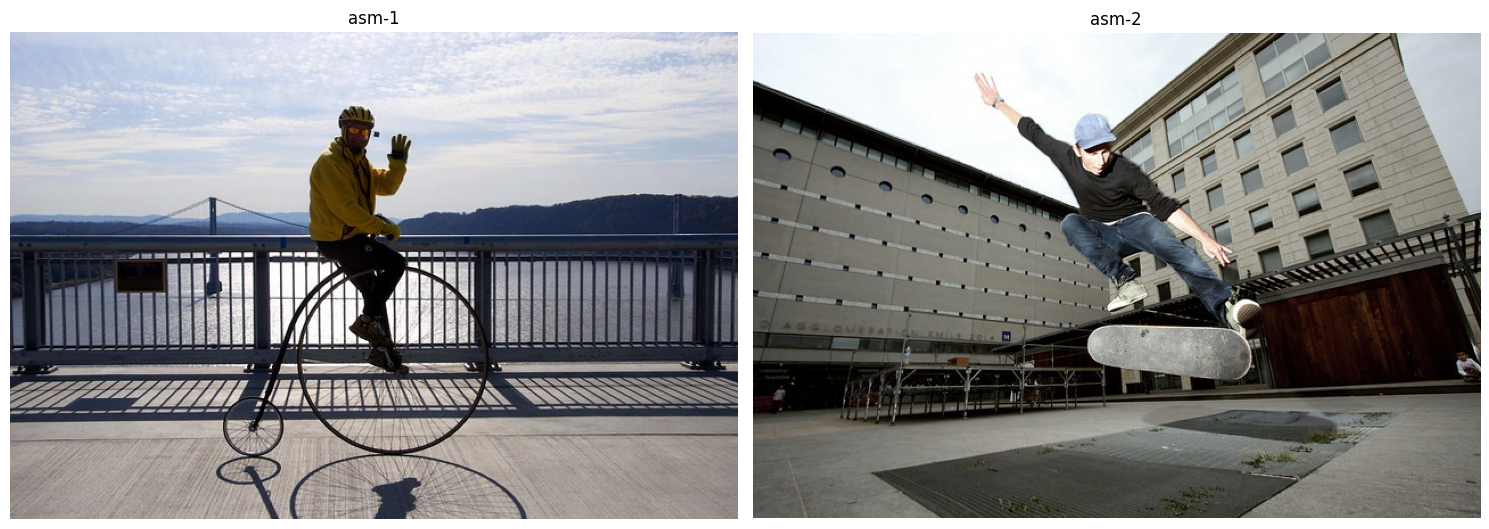

In [7]:
# Show sample images
show_images(input_images, image_names, 1, 2)

## Get bounding box

In [8]:
# Define a function to perform object detection
def get_person_bbox(image):
    # Convert OpenCV image (BGR) to RGB tensor
    img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img_tensor = transform_image(img_rgb).to(device).unsqueeze(0)

    # Get predictions
    with torch.no_grad():
        predictions = model(img_tensor)
    
    # Find the bounding box for the person class (class 1) with highest score
    best_bbox = None
    best_score = 0.0
    for box, label, score in zip(predictions[0]['boxes'], predictions[0]['labels'], predictions[0]['scores']):
        if label.item() == 1 and score.item() > best_score:
            best_score = score.item()
            best_bbox = box.cpu().numpy().astype(int)

    # Convert [x1, y1, x2, y2] to [x, y, w, h]
    if best_bbox is not None:
        x1, y1, x2, y2 = best_bbox
        return (x1, y1, x2 - x1, y2 - y1)
    else:
        return None

--- Processing asm-1 ---


Detected bounding box: x=263, y=63, w=89, h=235


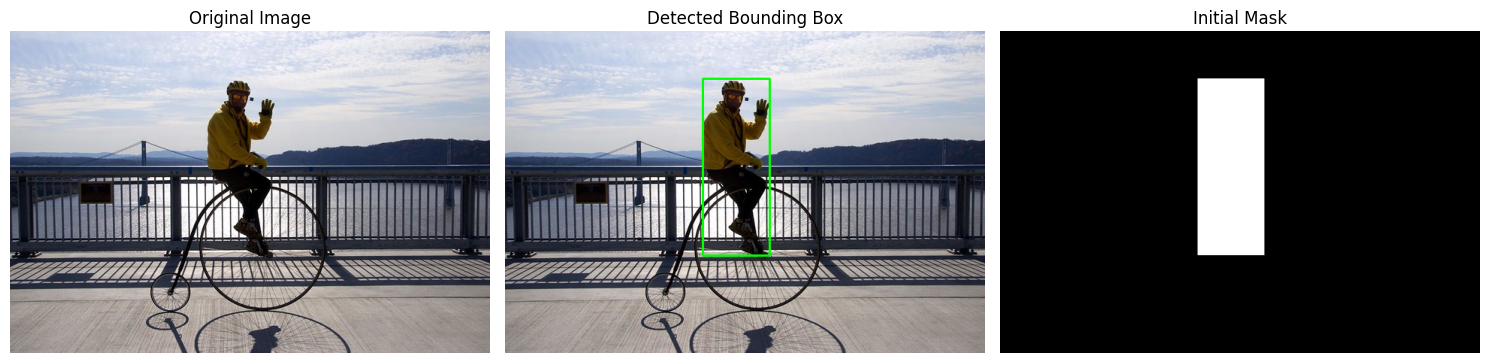

--- Processing asm-2 ---
Detected bounding box: x=190, y=46, w=259, h=205


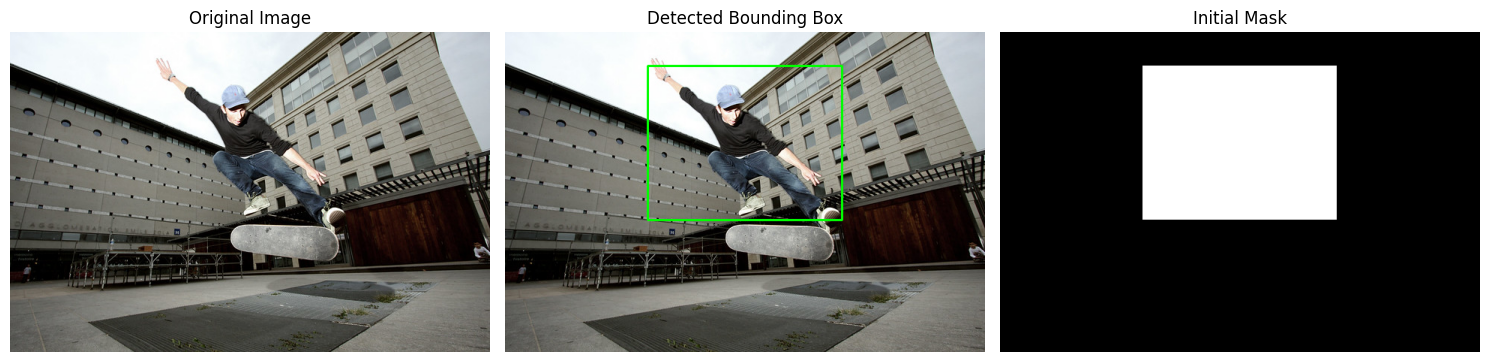

In [9]:
# Process the bounding boxes for each image
for img, name in zip(input_images, image_names):
    print(f"--- Processing {name} ---")
    
    # Get Bounding Box
    bbox = get_person_bbox(img)
    if bbox is None:
        print("No person detected in the image.")
        continue
    x, y, w, h = bbox
    print(f"Detected bounding box: x={x}, y={y}, w={w}, h={h}")

    # Draw bounding box on the image for visualization
    img_with_box = img.copy()
    cv2.rectangle(img_with_box, (x, y), (x + w, y + h), (0, 255, 0), 2)
    visuals = [img.copy(), img_with_box]

    # Create a mask from the bounding box
    mask = np.zeros(img.shape[:2], np.uint8)
    mask[y:y+h, x:x+w] = cv2.GC_PR_FGD  # Mark the bounding box area as probable foreground

    # Add mask visualization
    mask_viz = np.zeros_like(img)
    mask_viz[mask == cv2.GC_PR_FGD] = [255, 255, 255]
    visuals.append(mask_viz)

    # Show results
    titles = ['Original Image', 'Detected Bounding Box', 'Initial Mask']
    show_images(visuals, titles, 1, len(visuals))

## Run GrabCut Iteration Analysis

In [10]:
# Define GrabCut function
def apply_grabcut(image, mask, iterations):
    # Initialize background and foreground models
    bgdModel = np.zeros((1, 65), np.float64)
    fgdModel = np.zeros((1, 65), np.float64)

    # Apply GrabCut algorithm
    cv2.grabCut(image, mask, None, bgdModel, fgdModel, iterations, cv2.GC_INIT_WITH_MASK)

    # Create final mask where sure and probable foreground are marked as foreground
    final_mask = np.where((mask == cv2.GC_FGD) | (mask == cv2.GC_PR_FGD), 1, 0).astype('uint8')
    segmented_image = image * final_mask[:, :, np.newaxis]

    return segmented_image, final_mask

# Define a function to compute IoU
def compute_iou(mask_gt, mask_pred):
    intersection = np.logical_and(mask_gt, mask_pred)
    union = np.logical_or(mask_gt, mask_pred)
    iou = np.sum(intersection) / np.sum(union) if np.sum(union) != 0 else 0
    return iou


GrabCut Processing for asm-1
Detected bounding box: x=263, y=63, w=89, h=235

Processing 1 iteration(s)...
  - Foreground pixels: 13,260
  - Foreground ratio: 0.0485 (4.85%)
Detected bounding box: x=263, y=63, w=89, h=235

Processing 1 iteration(s)...
  - Foreground pixels: 13,260
  - Foreground ratio: 0.0485 (4.85%)


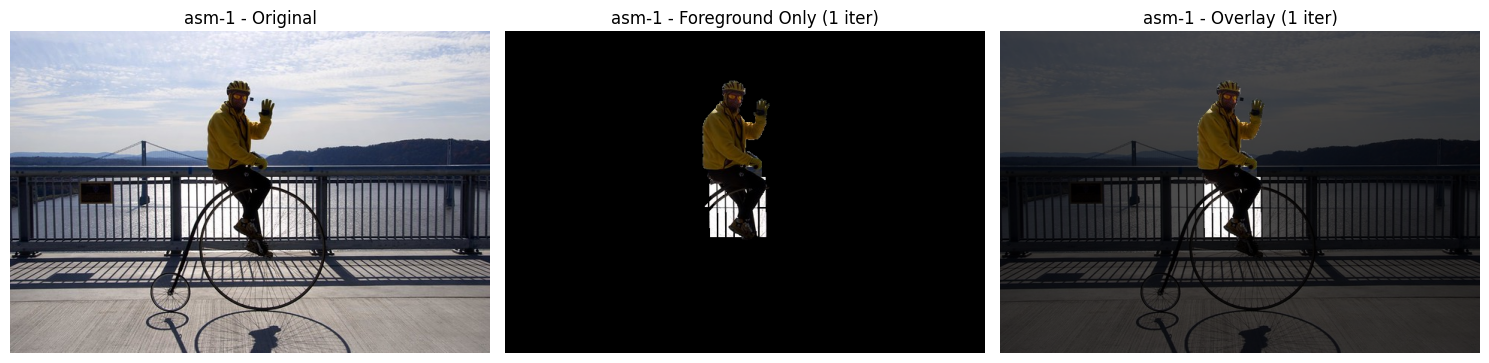


Processing 3 iteration(s)...
  - Foreground pixels: 13,158
  - Foreground ratio: 0.0481 (4.81%)


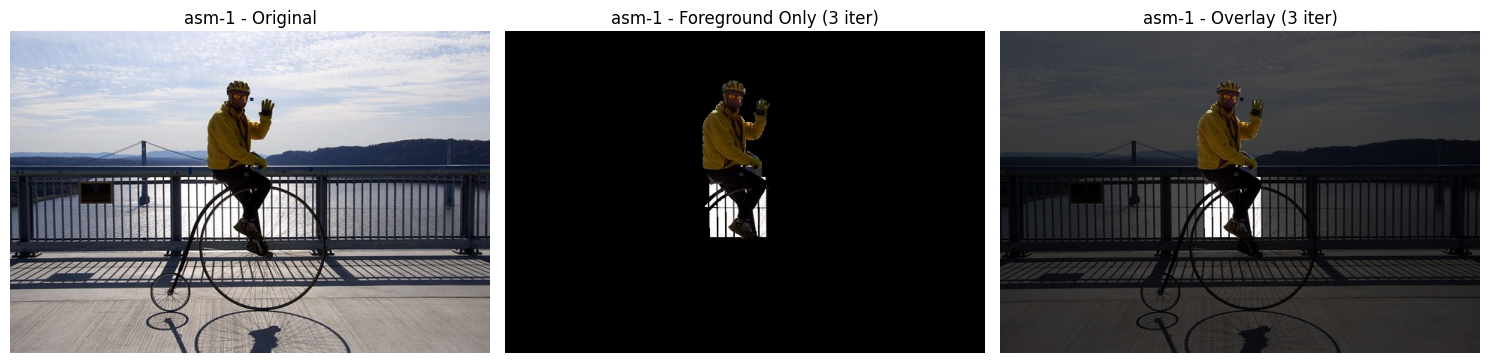


Processing 5 iteration(s)...
  - Foreground pixels: 13,111
  - Foreground ratio: 0.0479 (4.79%)
  - Foreground pixels: 13,111
  - Foreground ratio: 0.0479 (4.79%)


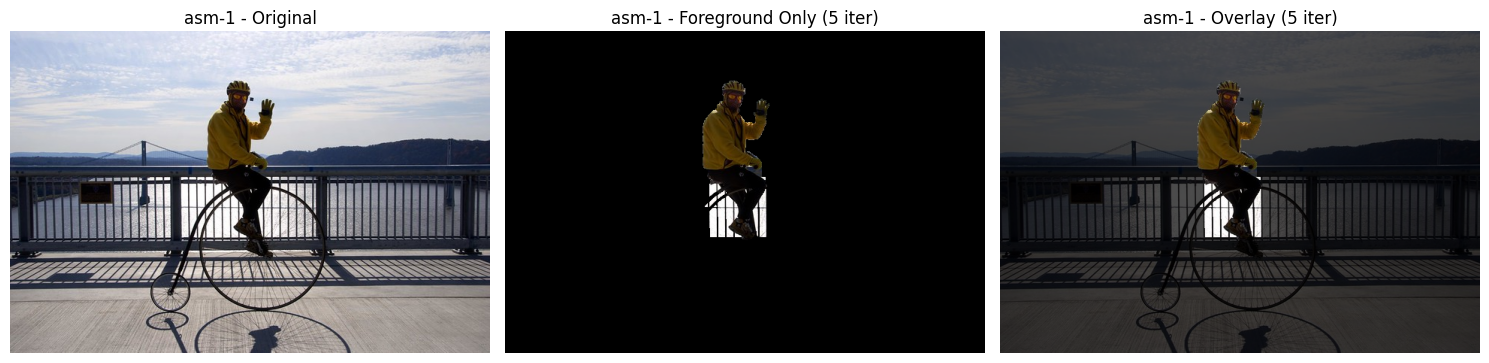


GrabCut Processing for asm-2
Detected bounding box: x=190, y=46, w=259, h=205

Processing 1 iteration(s)...
  - Foreground pixels: 21,324
  - Foreground ratio: 0.0780 (7.80%)
  - Foreground pixels: 21,324
  - Foreground ratio: 0.0780 (7.80%)


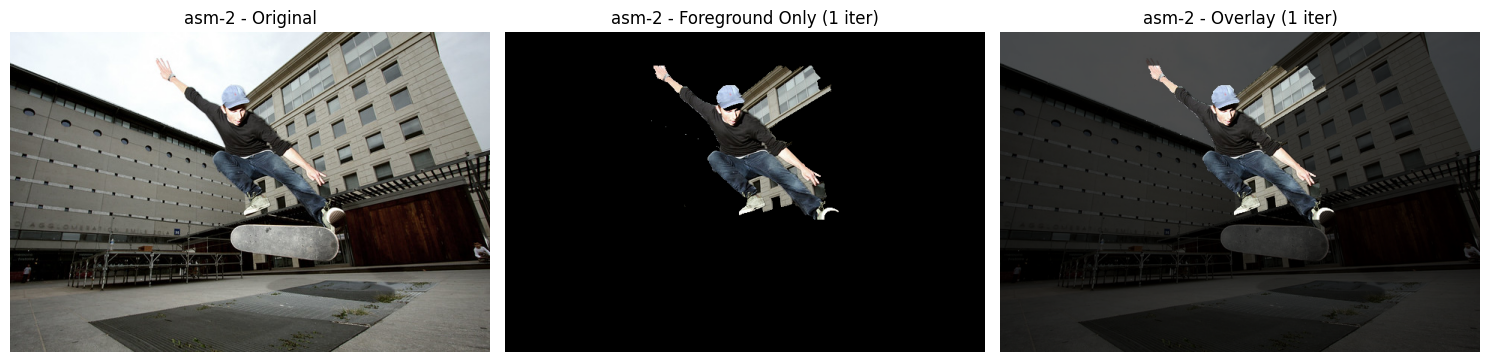


Processing 3 iteration(s)...
  - Foreground pixels: 25,478
  - Foreground ratio: 0.0932 (9.32%)
  - Foreground pixels: 25,478
  - Foreground ratio: 0.0932 (9.32%)


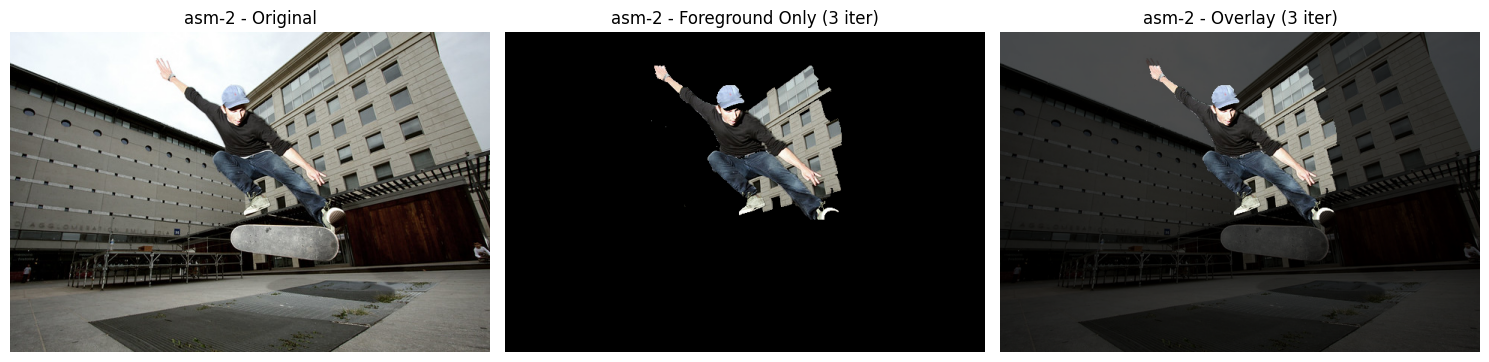


Processing 5 iteration(s)...
  - Foreground pixels: 14,097
  - Foreground ratio: 0.0516 (5.16%)
  - Foreground pixels: 14,097
  - Foreground ratio: 0.0516 (5.16%)


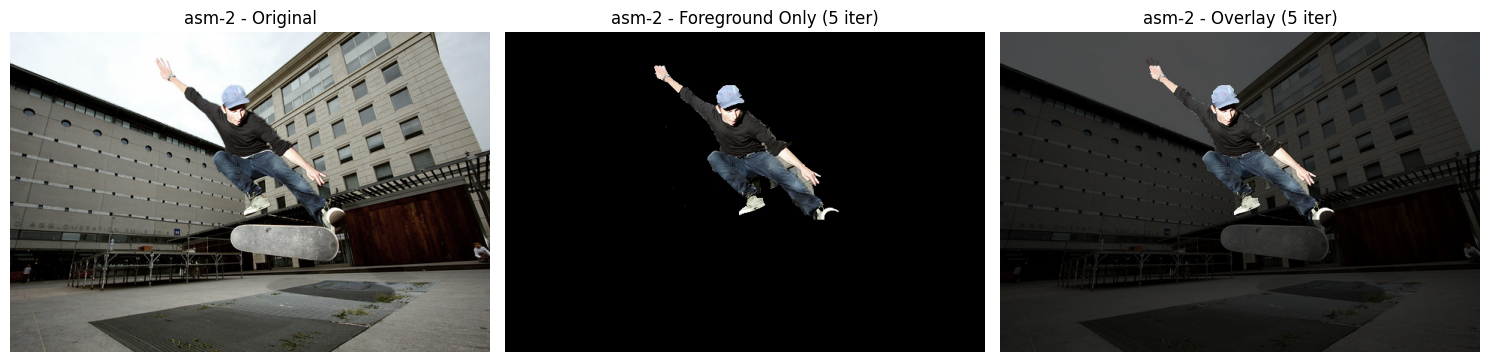


GrabCut processing completed for all images!


In [11]:
# Run GrabCut for 1, 3, and 5 iterations — report qualitative and quantitative differences.
# Store results for comparison
all_results = {}

for img, name in zip(input_images, image_names):
    print(f"\n{'='*60}")
    print(f"GrabCut Processing for {name}")
    print(f"{'='*60}")
    
    # Get Bounding Box
    bbox = get_person_bbox(img)
    if bbox is None:
        print("No person detected in the image.")
        continue
    x, y, w, h = bbox
    print(f"Detected bounding box: x={x}, y={y}, w={w}, h={h}")

    # Store results for this image
    all_results[name] = {
        'original': img.copy(),
        'bbox': bbox,
        'iterations': {}
    }

    # Create initial mask
    initial_mask = np.zeros(img.shape[:2], np.uint8)
    initial_mask[y:y+h, x:x+w] = cv2.GC_PR_FGD  # Mark the bounding box area as probable foreground

    for iters in grabcut_iter:
        print(f"\nProcessing {iters} iteration(s)...")
        
        # Apply GrabCut
        segmented_img, final_mask = apply_grabcut(img, initial_mask.copy(), iters)
        
        # Create overlay (blend original and segmentation)
        overlay = img.copy()
        overlay[final_mask == 0] = overlay[final_mask == 0] * 0.3  # Darken background
        
        # Calculate metrics - cast to int to avoid unsigned integer overflow
        foreground_pixels = int(np.sum(final_mask))
        total_pixels = int(final_mask.size)
        foreground_ratio = foreground_pixels / total_pixels
        
        # Store results
        all_results[name]['iterations'][iters] = {
            'segmented': segmented_img,
            'mask': final_mask,
            'overlay': overlay,
            'fg_pixels': foreground_pixels,
            'fg_ratio': foreground_ratio
        }
        
        print(f"  - Foreground pixels: {foreground_pixels:,}")
        print(f"  - Foreground ratio: {foreground_ratio:.4f} ({foreground_ratio*100:.2f}%)")
        
        # Visualize results for this iteration
        visuals = [img, segmented_img, overlay]
        titles = [
            f'{name} - Original',
            f'{name} - Foreground Only ({iters} iter)',
            f'{name} - Overlay ({iters} iter)'
        ]
        show_images(visuals, titles, 1, 3)

print("\n" + "="*60)
print("GrabCut processing completed for all images!")
print("="*60)

## Qualitative and Quantitative Analysis


Analysis for asm-1

Quantitative Metrics:
------------------------------------------------------------
Iterations   Foreground Pixels    Foreground Ratio    
------------------------------------------------------------
1            13,260               0.0485              
3            13,158               0.0481              
5            13,111               0.0479              

Iteration Changes:
------------------------------------------------------------
  1 → 3 iterations:
    Pixel change: -102 pixels
    Ratio change: -0.000373 (-0.0373%)
  3 → 5 iterations:
    Pixel change: -47 pixels
    Ratio change: -0.000172 (-0.0172%)

Qualitative Comparison - Foreground Only:


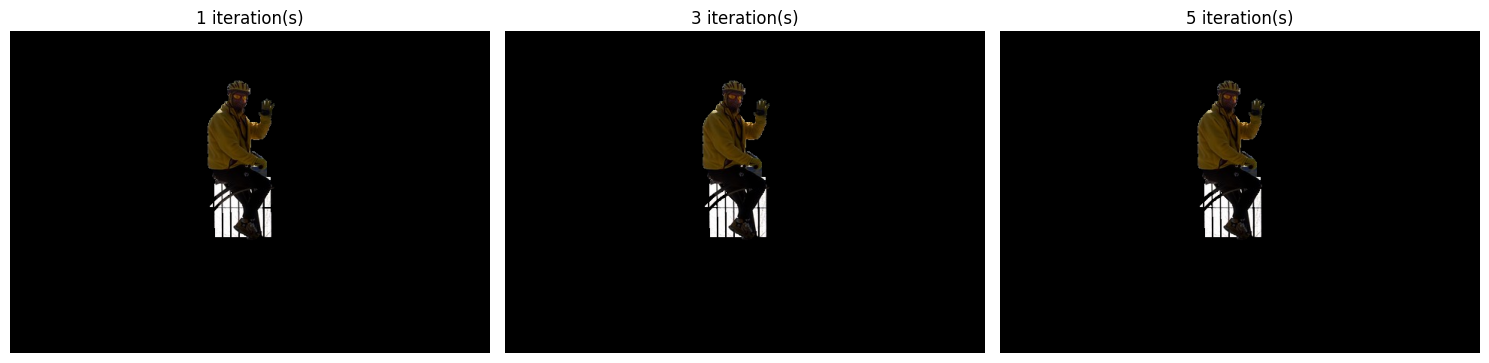

Qualitative Comparison - Overlay:


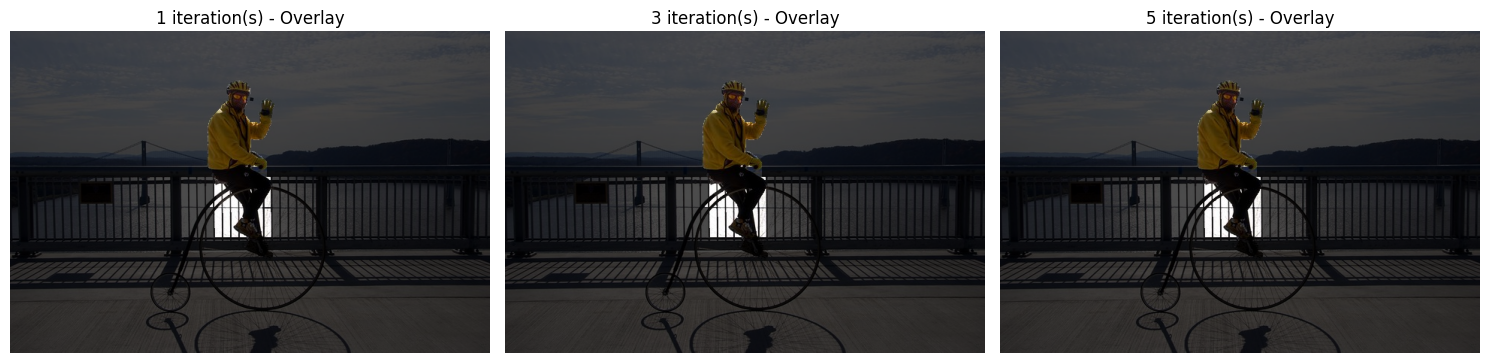

Qualitative Comparison - Masks:


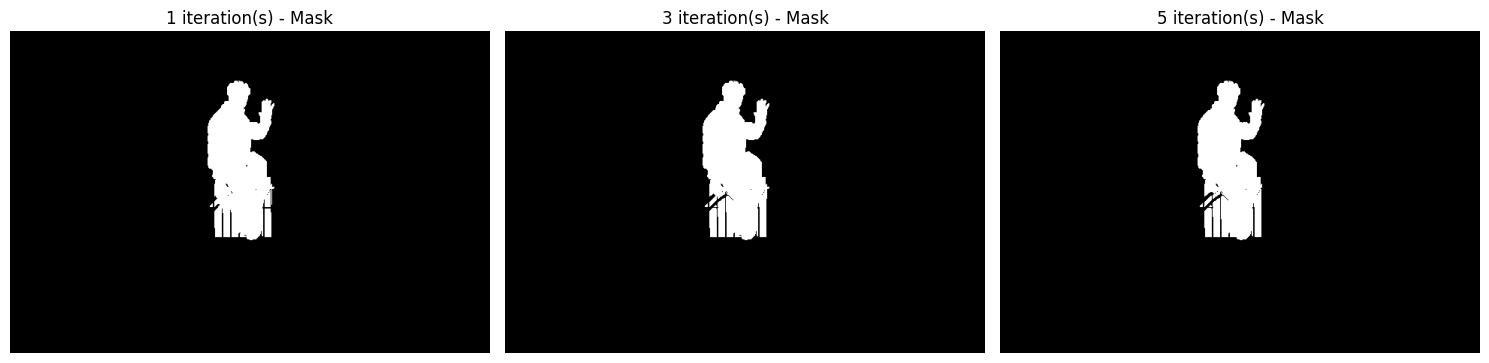


Analysis for asm-2

Quantitative Metrics:
------------------------------------------------------------
Iterations   Foreground Pixels    Foreground Ratio    
------------------------------------------------------------
1            21,324               0.0780              
3            25,478               0.0932              
5            14,097               0.0516              

Iteration Changes:
------------------------------------------------------------
  1 → 3 iterations:
    Pixel change: +4,154 pixels
    Ratio change: +0.015201 (+1.5201%)
  3 → 5 iterations:
    Pixel change: -11,381 pixels
    Ratio change: -0.041646 (-4.1646%)

Qualitative Comparison - Foreground Only:


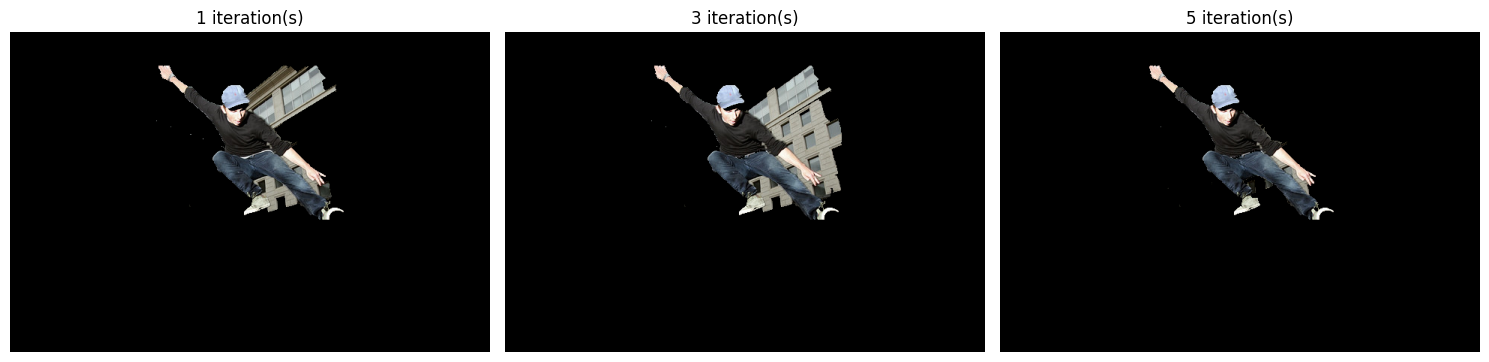

Qualitative Comparison - Overlay:


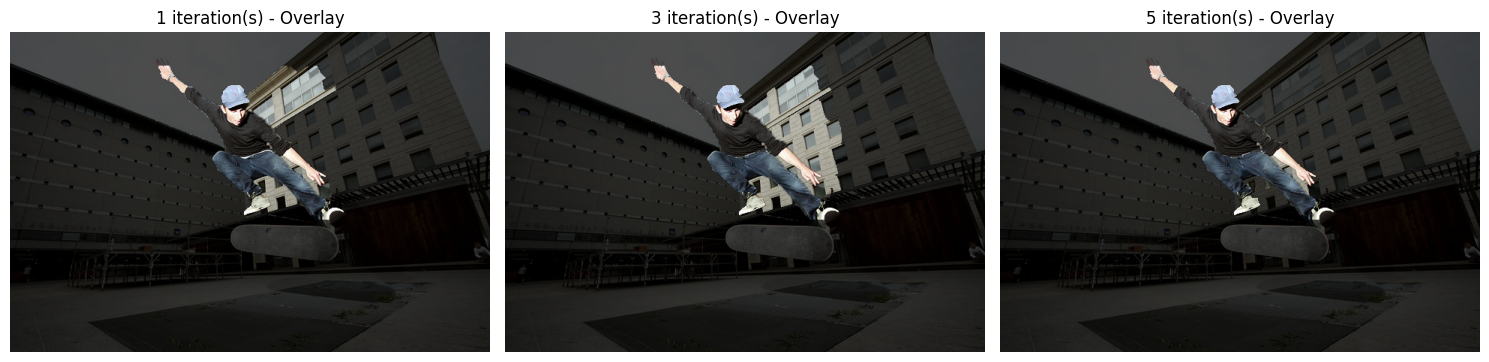

Qualitative Comparison - Masks:


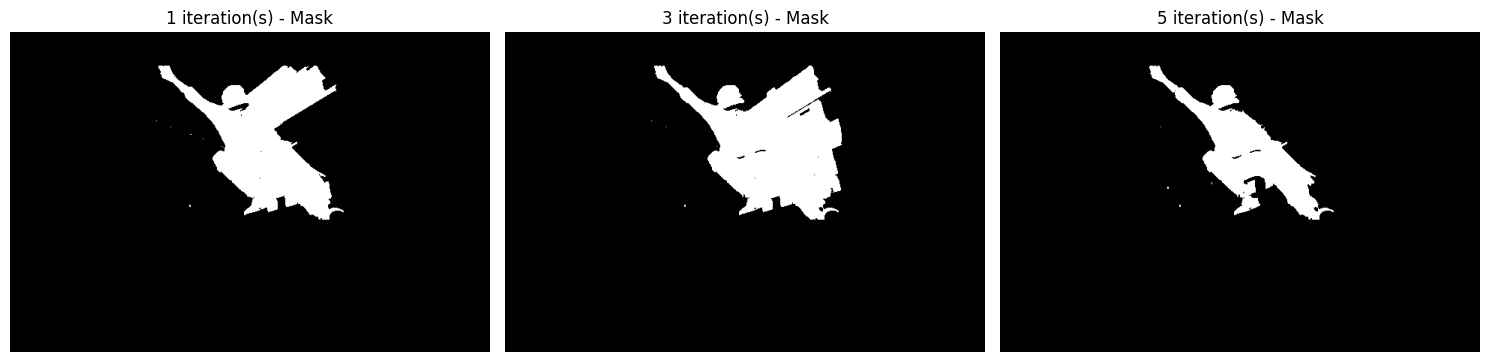

In [12]:
# Comprehensive comparison across iterations for each image
for name in image_names:
    if name not in all_results:
        continue
        
    print(f"\n{'='*60}")
    print(f"Analysis for {name}")
    print(f"{'='*60}\n")
    
    results = all_results[name]
    
    # Quantitative Analysis
    print("Quantitative Metrics:")
    print("-" * 60)
    print(f"{'Iterations':<12} {'Foreground Pixels':<20} {'Foreground Ratio':<20}")
    print("-" * 60)
    
    for iters in grabcut_iter:
        iter_data = results['iterations'][iters]
        print(f"{iters:<12} {iter_data['fg_pixels']:<20,} {iter_data['fg_ratio']:<20.4f}")
    
    # Calculate differences between iterations
    print(f"\n{'Iteration Changes:'}")
    print("-" * 60)
    for i in range(len(grabcut_iter) - 1):
        iter1 = grabcut_iter[i]
        iter2 = grabcut_iter[i + 1]
        data1 = results['iterations'][iter1]
        data2 = results['iterations'][iter2]
        
        # Ensure integer arithmetic to avoid overflow
        pixel_change = int(data2['fg_pixels']) - int(data1['fg_pixels'])
        ratio_change = data2['fg_ratio'] - data1['fg_ratio']
        
        print(f"  {iter1} → {iter2} iterations:")
        print(f"    Pixel change: {pixel_change:+,} pixels")
        print(f"    Ratio change: {ratio_change:+.6f} ({ratio_change*100:+.4f}%)")
    
    # Side-by-side comparison visualization
    print(f"\n{'Qualitative Comparison - Foreground Only:'}")
    comparison_imgs = [results['iterations'][iters]['segmented'] for iters in grabcut_iter]
    comparison_titles = [f'{iters} iteration(s)' for iters in grabcut_iter]
    show_images(comparison_imgs, comparison_titles, 1, 3)
    
    # Overlay comparison
    print(f"{'Qualitative Comparison - Overlay:'}")
    overlay_imgs = [results['iterations'][iters]['overlay'] for iters in grabcut_iter]
    overlay_titles = [f'{iters} iteration(s) - Overlay' for iters in grabcut_iter]
    show_images(overlay_imgs, overlay_titles, 1, 3)
    
    # Mask comparison
    print(f"{'Qualitative Comparison - Masks:'}")
    mask_imgs = [results['iterations'][iters]['mask'] * 255 for iters in grabcut_iter]
    mask_titles = [f'{iters} iteration(s) - Mask' for iters in grabcut_iter]
    show_images(mask_imgs, mask_titles, 1, 3)

## Summary and Conclusions

The goal of this task was to perform image segmentation on two images, `asm-1` and `asm-2`. The process involved two main steps:

1.  **Object Detection:** A pre-trained deep learning model (Faster R-CNN) was used to automatically find a person in each image and generate a bounding box.
2.  **Segmentation:** The OpenCV `grabCut` function was used to separate the person (foreground) from the background. This function was initialized using the bounding box from the first step.

The core of the analysis was to run the `grabCut` algorithm for **1, 3, and 5 iterations** and then compare the results both quantitatively (by counting pixels) and qualitatively (by visual inspection).

---

### Analysis of Results

The results for each image were analyzed to see how the segmentation changed as the number of iterations increased.

#### Image 1: `asm-1` (Man on bicycle)

**Quantitative Analysis**

| Iterations | Foreground Pixels | Foreground Ratio |
| :--- | :--- | :--- |
| 1 | 13,260 | 0.0485 |
| 3 | 13,158 | 0.0481 |
| 5 | 13,111 | 0.0479 |

**Qualitative Analysis**

For `asm-1`, the results were very consistent.
* The number of foreground pixels decreased slightly with more iterations, showing minor refinements.
* Visually, the segmented images for 1, 3, and 5 iterations are nearly identical. This suggests that the algorithm found a good and stable solution in the very first iteration, and more steps only made very small adjustments.

#### Image 2: `asm-2` (Skateboarder)

**Quantitative Analysis**

| Iterations | Foreground Pixels | Foreground Ratio |
| :--- | :--- | :--- |
| 1 | 21,324 | 0.0780 |
| 3 | 25,478 | 0.0932 |
| 5 | 14,097 | 0.0516 |

**Qualitative Analysis**

For `asm-2`, the results were much more varied and showed a more complex process.
* **1 to 3 iterations:** The pixel count *increased* significantly. The qualitative images show why: the 3-iteration result incorrectly included a large part of the background building as part of the foreground.
* **3 to 5 iterations:** The pixel count *dropped* dramatically. The 5-iteration image shows that the algorithm corrected its previous mistake, removing the background building and producing a much cleaner and more accurate segmentation of just the skateboarder.

### Conclusion

This analysis demonstrates that simply increasing iterations does not guarantee a progressively better result.
* In the simple case (`asm-1`), the segmentation was stable from the start, and more iterations had little effect.
* In the more complex case (`asm-2`), the algorithm's result temporarily became worse (at 3 iterations) before it found a much-improved solution (at 5 iterations). This shows that for challenging images, more iterations can be necessary to allow the algorithm to converge on a correct solution and fix initial errors.